In [1]:
#Q1-1
#professor canceled this part

<Figure size 1000x800 with 0 Axes>

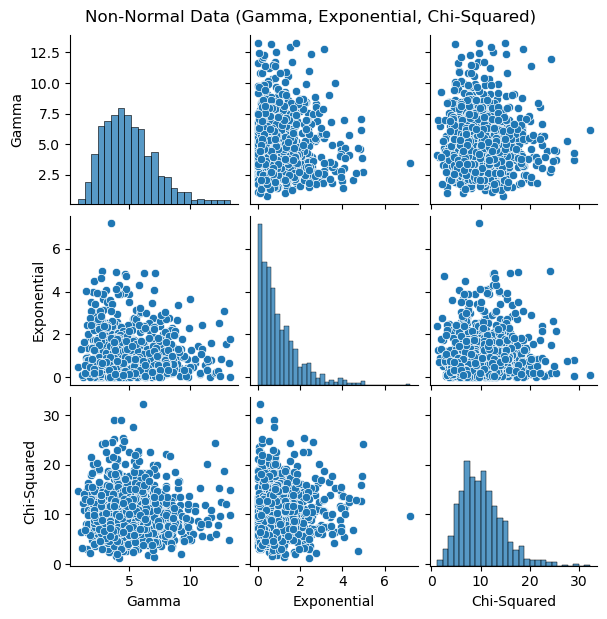

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Estimated parameters:
Gamma: alpha = 5.3000, beta = 1.0600
Exponential: lambda = 1.0000
Chi-squared: nu = 10.2910


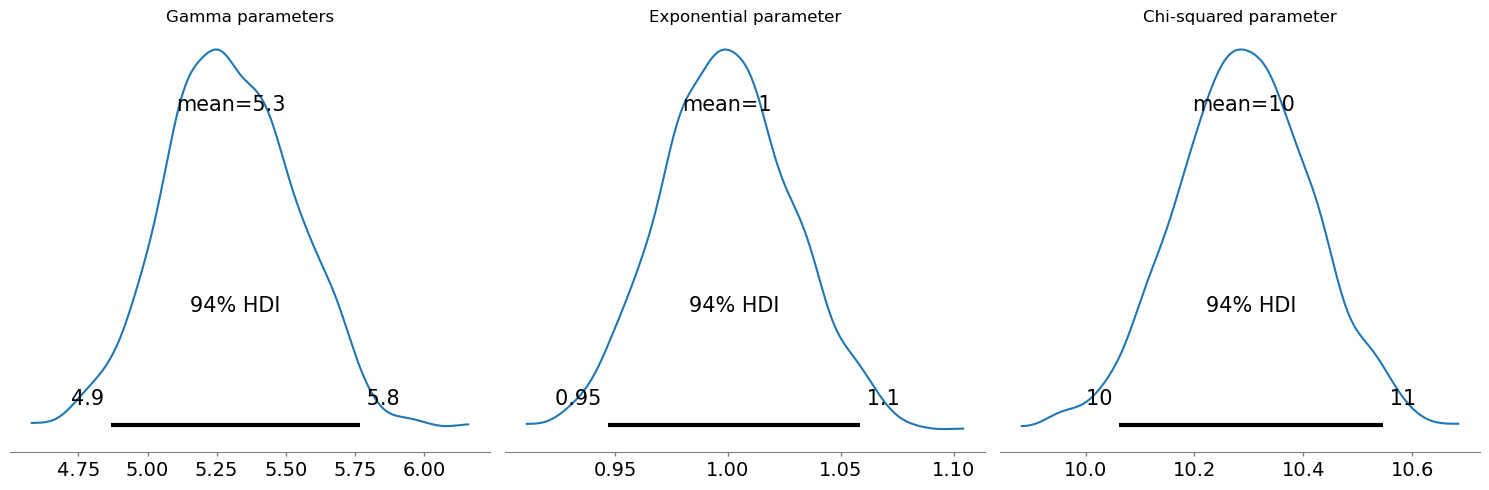

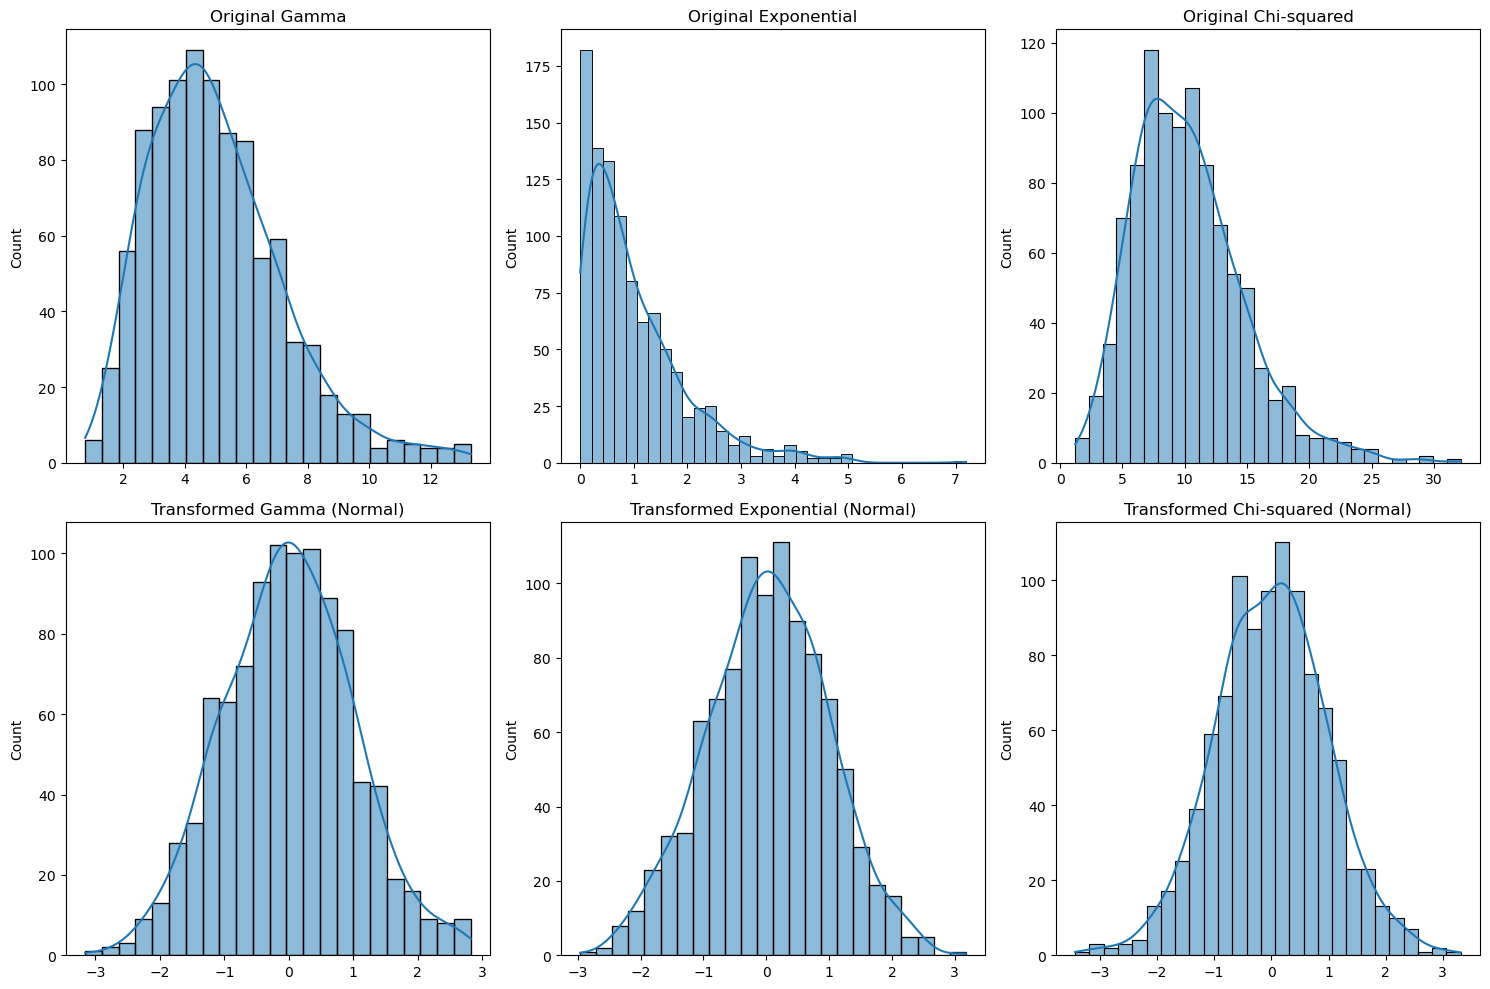

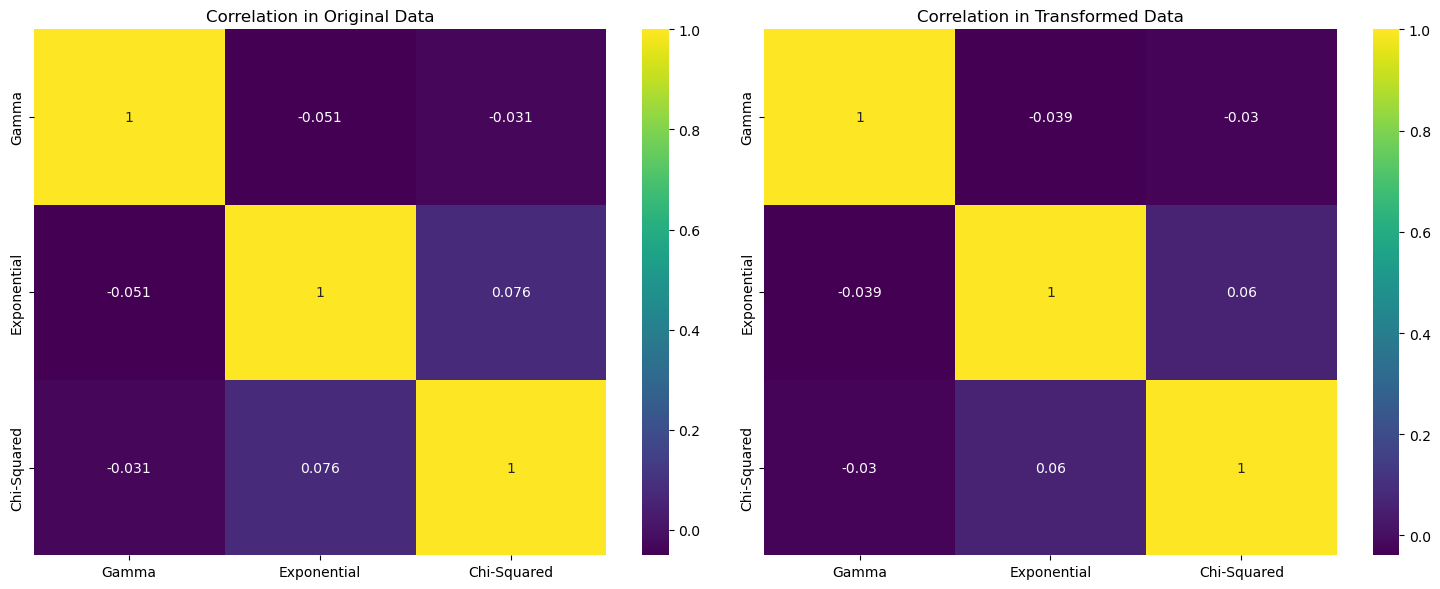

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [corr]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
/opt/conda/lib/python3.11/site-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'dim'} appear more than once in dims=('chain', 'draw', 'dim', 'dim'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)
We recommend running at least 4 chains for robust computation of convergence diagnostics



Copula model correlation matrix:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
corr[0]  1.003  0.023   0.957    1.044      0.000    0.000    2134.0   
corr[1] -0.036  0.032  -0.094    0.024      0.001    0.001    2559.0   
corr[2]  0.969  0.022   0.929    1.008      0.000    0.001    1909.0   
corr[3] -0.029  0.032  -0.091    0.027      0.001    0.001    2666.0   
corr[4]  0.059  0.031   0.001    0.117      0.001    0.001    2968.0   
corr[5]  0.980  0.022   0.944    1.024      0.000    0.000    2071.0   

         ess_tail  r_hat  
corr[0]    1351.0    1.0  
corr[1]    1488.0    1.0  
corr[2]    1463.0    1.0  
corr[3]    1644.0    1.0  
corr[4]    1828.0    1.0  
corr[5]    1685.0    1.0  


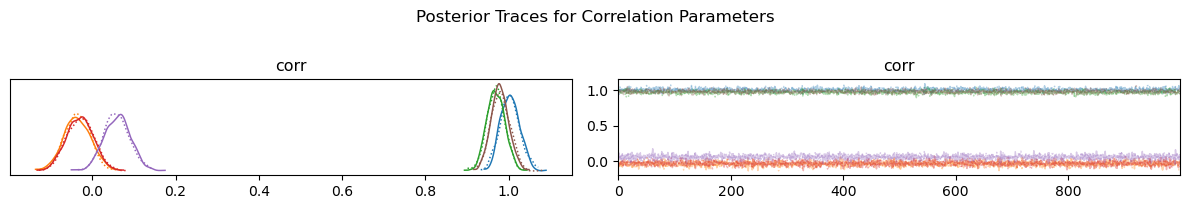

/tmp/ipykernel_1222/3344380888.py:170: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  random_idx = np.random.randint(0, copula_trace.posterior.dims["draw"])


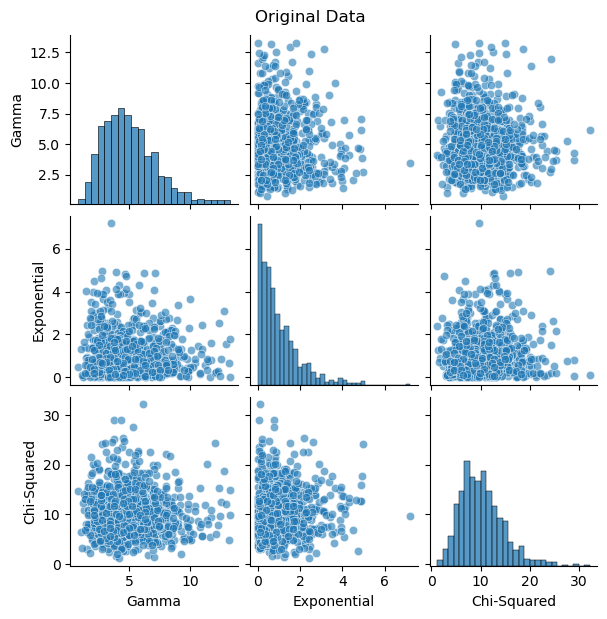

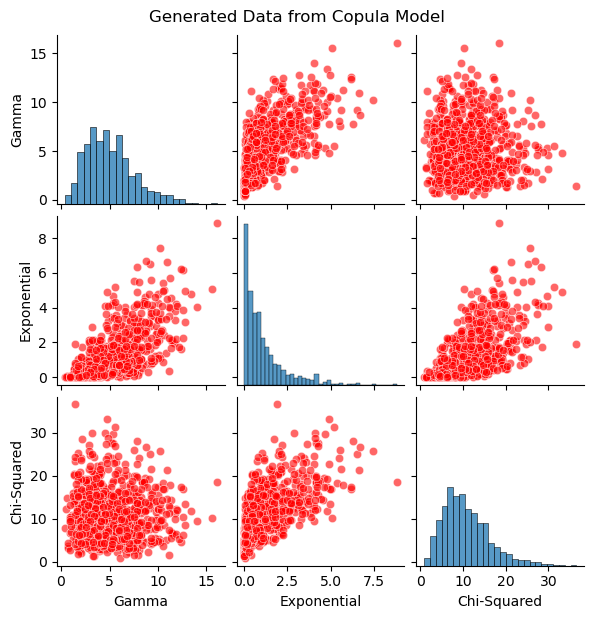

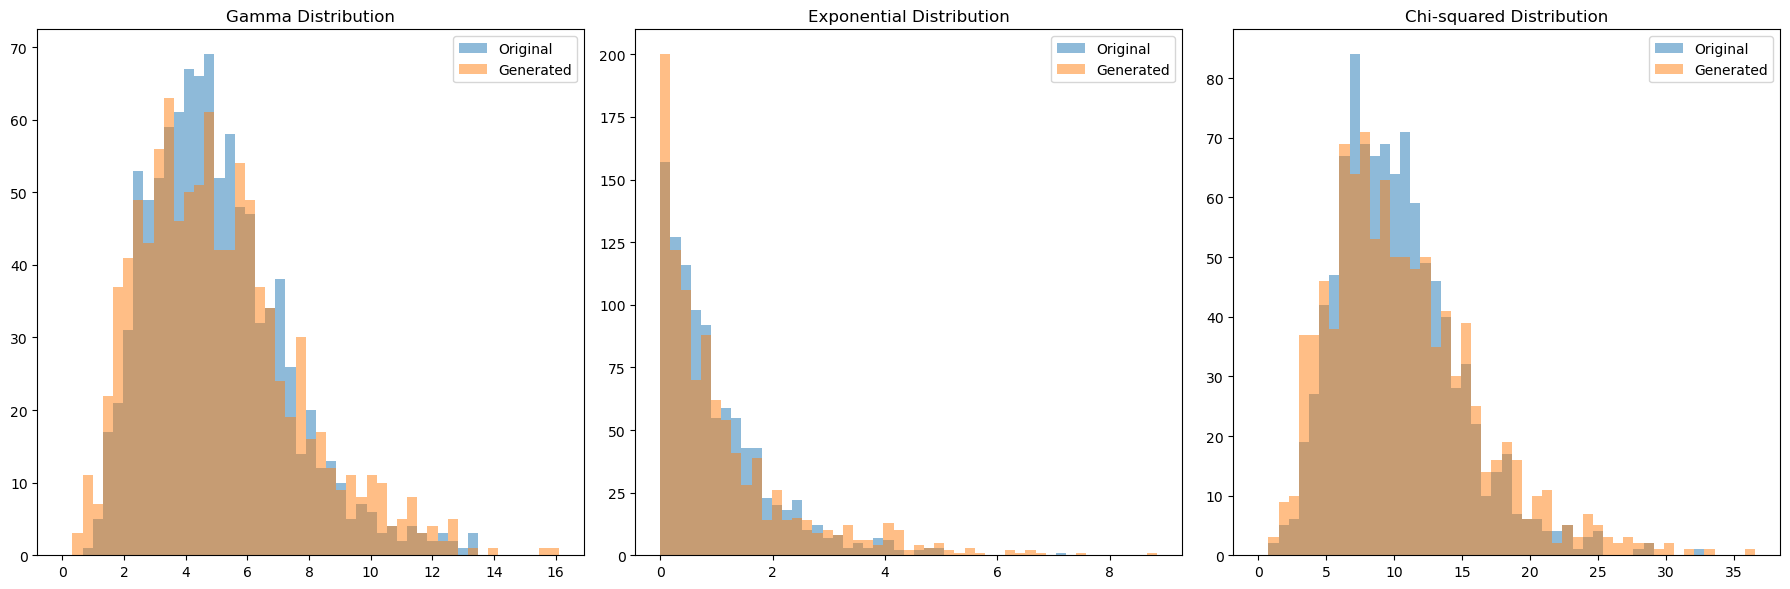

In [1]:
# Q1-2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma, expon, chi2, norm
import pymc as pm
import arviz as az

np.random.seed(1007818630)

# Generate non-normal data
n = 1000
data = np.column_stack([
    gamma(a=5).rvs(n), 
    expon(scale=1).rvs(n), 
    chi2(df=10).rvs(n) 
])

# Convert to DataFrame for visualization
df = pd.DataFrame(data, columns=["Gamma", "Exponential", "Chi-Squared"])

# Visualize the raw data
plt.figure(figsize=(10, 8))
sns.pairplot(df, height=2)
plt.suptitle("Non-Normal Data (Gamma, Exponential, Chi-Squared)", y=1.02)
plt.show()

# FIRST PASS: Estimating marginal distributions independently
coords = {"obs_id": np.arange(n)}

# First marginal model: Gamma distribution
with pm.Model(coords=coords) as gamma_model:
    # We could use a spike-and-slab or horseshoe prior here to allow 
    # for potential sparsity, but for simple marginal estimation, we use standard priors
    alpha = pm.HalfNormal("alpha", sigma=10)
    beta = pm.HalfNormal("beta", sigma=10)
    gamma_obs = pm.Gamma("gamma_obs", alpha=alpha, beta=beta, observed=data[:, 0], dims="obs_id")
    gamma_trace = pm.sample(draws=1000, tune=500, chains=2, cores=2, random_seed=1007818630)

# Second marginal model: Exponential distribution
with pm.Model(coords=coords) as exponential_model:
    lam = pm.HalfNormal("lam", sigma=10)
    exponential_obs = pm.Exponential("exponential_obs", lam=lam, observed=data[:, 1], dims="obs_id")
    exponential_trace = pm.sample(draws=1000, tune=500, chains=2, cores=2, random_seed=1007818630)

# Third marginal model: Chi-squared distribution
with pm.Model(coords=coords) as chi2_model:
    nu = pm.HalfNormal("nu", sigma=10)
    chi2_obs = pm.ChiSquared("chi2_obs", nu=nu, observed=data[:, 2], dims="obs_id")
    chi2_trace = pm.sample(draws=1000, tune=500, chains=2, cores=2, random_seed=1007818630)

# Extract posterior means for marginal parameters
alpha_mean = az.summary(gamma_trace, var_names=["alpha"])["mean"].values[0]
beta_mean = az.summary(gamma_trace, var_names=["beta"])["mean"].values[0]
lam_mean = az.summary(exponential_trace, var_names=["lam"])["mean"].values[0]
nu_mean = az.summary(chi2_trace, var_names=["nu"])["mean"].values[0]

print("Estimated parameters:")
print(f"Gamma: alpha = {alpha_mean:.4f}, beta = {beta_mean:.4f}")
print(f"Exponential: lambda = {lam_mean:.4f}")
print(f"Chi-squared: nu = {nu_mean:.4f}")

# Visualize the marginal posteriors
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
az.plot_posterior(gamma_trace, var_names=["alpha", "beta"], ax=axes[0])
axes[0].set_title("Gamma parameters")
az.plot_posterior(exponential_trace, var_names=["lam"], ax=axes[1])
axes[1].set_title("Exponential parameter")
az.plot_posterior(chi2_trace, var_names=["nu"], ax=axes[2])
axes[2].set_title("Chi-squared parameter")
plt.tight_layout()
plt.show()

# SECOND PASS: Transform data to uniform space and then to multivariate normal space
u1 = gamma.cdf(data[:, 0], alpha_mean, scale=1/beta_mean)
u2 = expon.cdf(data[:, 1], scale=1/lam_mean)
u3 = chi2.cdf(data[:, 2], df=nu_mean)

# Transform to multivariate normal space
z1 = norm.ppf(u1)
z2 = norm.ppf(u2)
z3 = norm.ppf(u3)

# Combine into matrix of pseudo-observations
pseudo_observations = np.column_stack([z1, z2, z3])

# Visualize the transformations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original data
sns.histplot(data[:, 0], ax=axes[0, 0], kde=True)
axes[0, 0].set_title("Original Gamma")
sns.histplot(data[:, 1], ax=axes[0, 1], kde=True)
axes[0, 1].set_title("Original Exponential")
sns.histplot(data[:, 2], ax=axes[0, 2], kde=True)
axes[0, 2].set_title("Original Chi-squared")

# Transformed data
sns.histplot(z1, ax=axes[1, 0], kde=True)
axes[1, 0].set_title("Transformed Gamma (Normal)")
sns.histplot(z2, ax=axes[1, 1], kde=True)
axes[1, 1].set_title("Transformed Exponential (Normal)")
sns.histplot(z3, ax=axes[1, 2], kde=True)
axes[1, 2].set_title("Transformed Chi-squared (Normal)")

plt.tight_layout()
plt.show()

# Plot correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Correlation in original data
corr_original = np.corrcoef(data, rowvar=False)
sns.heatmap(corr_original, annot=True, cmap="viridis", 
            xticklabels=["Gamma", "Exponential", "Chi-Squared"],
            yticklabels=["Gamma", "Exponential", "Chi-Squared"],
            ax=axes[0])
axes[0].set_title("Correlation in Original Data")

# Correlation in transformed data
corr_transformed = np.corrcoef(pseudo_observations, rowvar=False)
sns.heatmap(corr_transformed, annot=True, cmap="viridis",
            xticklabels=["Gamma", "Exponential", "Chi-Squared"],
            yticklabels=["Gamma", "Exponential", "Chi-Squared"],
            ax=axes[1])
axes[1].set_title("Correlation in Transformed Data")

plt.tight_layout()
plt.show()


# Fit the Gaussian Copula Model (Second Pass)
coords.update({"dim": ["Gamma", "Exponential", "Chi-Squared"]})

with pm.Model(coords=coords) as copula_model:
    # LKJ Cholesky Covariance Prior
    chol, corr, stds = pm.LKJCholeskyCov(
        "corr", n=3, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    
    # Covariance matrix
    cov = pm.Deterministic("cov", chol @ chol.T, dims=("dim", "dim"))
    
    # Multivariate Normal Copula
    mvnormal = pm.MvNormal("mvnormal", mu=np.zeros(3), cov=cov, observed=pseudo_observations)
    
    # Sample from the copula model
    copula_trace = pm.sample(draws=1000, tune=500, chains=2, cores=2, random_seed=1007818630)

# Analyze the results
print("\nCopula model correlation matrix:")
correlation_summary = az.summary(copula_trace, var_names=["corr"])
print(correlation_summary)

# Visualize the correlation matrix posteriors
az.plot_trace(copula_trace, var_names=["corr"])
plt.suptitle("Posterior Traces for Correlation Parameters", y=1.02)
plt.tight_layout()
plt.show()

# Extract a sample correlation matrix for visualization - fixing the previous issue
random_idx = np.random.randint(0, copula_trace.posterior.dims["draw"])
sample_corr = copula_trace.posterior.corr.isel(chain=0, draw=random_idx).values

# Create a proper correlation matrix
corr_matrix = np.array([
    [1.0, sample_corr[0], sample_corr[1]],
    [sample_corr[0], 1.0, sample_corr[2]],
    [sample_corr[1], sample_corr[2], 1.0]
])

# Force symmetry and positive-definiteness
corr_matrix = (corr_matrix + corr_matrix.T) / 2 
min_eig = np.min(np.linalg.eigvals(corr_matrix))
if min_eig < 0:
    corr_matrix += (-min_eig + 1e-6) * np.eye(3)

# Generate samples from the estimated copula
mvn_samples = np.random.multivariate_normal(np.zeros(3), corr_matrix, size=1000)

# Transform back to uniform space
u1_gen = norm.cdf(mvn_samples[:, 0])
u2_gen = norm.cdf(mvn_samples[:, 1])
u3_gen = norm.cdf(mvn_samples[:, 2])

# Transform to original scale
x1_gen = gamma.ppf(u1_gen, alpha_mean, scale=1/beta_mean)
x2_gen = expon.ppf(u2_gen, scale=1/lam_mean)
x3_gen = chi2.ppf(u3_gen, df=nu_mean)

# Create DataFrame for visualization
df_gen = pd.DataFrame({
    "Gamma": x1_gen,
    "Exponential": x2_gen,
    "Chi-Squared": x3_gen
})

# Original data pairplot
g1 = sns.pairplot(df, height=2, plot_kws={'alpha': 0.6})
g1.fig.suptitle("Original Data", y=1.02)
plt.show()

# Generated data pairplot
g2 = sns.pairplot(df_gen, height=2, plot_kws={'alpha': 0.6, 'color': 'red'})
g2.fig.suptitle("Generated Data from Copula Model", y=1.02)
plt.show()

# Evaluate model performance by comparing joint distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Compare Gamma marginals
bins = np.linspace(0, np.max([data[:, 0].max(), x1_gen.max()]), 50)
axes[0].hist(data[:, 0], bins=bins, alpha=0.5, label="Original")
axes[0].hist(x1_gen, bins=bins, alpha=0.5, label="Generated")
axes[0].set_title("Gamma Distribution")
axes[0].legend()

# Compare Exponential marginals
bins = np.linspace(0, np.max([data[:, 1].max(), x2_gen.max()]), 50)
axes[1].hist(data[:, 1], bins=bins, alpha=0.5, label="Original")
axes[1].hist(x2_gen, bins=bins, alpha=0.5, label="Generated")
axes[1].set_title("Exponential Distribution")
axes[1].legend()

# Compare Chi-squared marginals
bins = np.linspace(0, np.max([data[:, 2].max(), x3_gen.max()]), 50)
axes[2].hist(data[:, 2], bins=bins, alpha=0.5, label="Original")
axes[2].hist(x3_gen, bins=bins, alpha=0.5, label="Generated")
axes[2].set_title("Chi-squared Distribution")
axes[2].legend()

plt.tight_layout()
plt.show()

#### Q1-3
A copula is a function that links univariate marginal distributions to form a full multivariate distribution, allowing for flexible modeling of complex dependencies while preserving individual distribution characteristics. According to Sklar’s Theorem, any multivariate distribution can be expressed as a combination of its marginals and a copula that binds them together, making copulas useful for modeling dependencies independently of the marginals.  

In the one-pass approach (direct fitting), the model jointly estimates both marginal parameters and the latent correlation structure within a single model through deterministic transformations. This approach is theoretically superior because it captures full posterior uncertainty and maintains consistent dependency modeling. However, it is computationally intensive and prone to slow convergence, especially in high-dimensional settings.  

The two-pass approach first estimates the marginal distributions independently and then transforms the observed data to a common (usually Gaussian) scale using the inverse cumulative distribution function (or PPF). A separate model then estimates the dependency structure using an LKJ prior on the correlation matrix, implementing a Gaussian copula. This approach reduces computational complexity, making it faster and more efficient for large datasets, but it sacrifices some accuracy by treating marginal and dependency estimation as separate processes, which may underestimate joint variability.  

While the one-pass approach is theoretically more robust and accurate in capturing the full joint posterior distribution, it is often impractical due to its computational demands. The two-pass approach, despite its limitations in fully capturing parameter uncertainty, is more feasible for real-world applications due to its computational efficiency.

#### Q1-4
By using copulas, we can separate marginal model specification from the dependency structure, allowing for flexible construction of multivariate generalized linear models (GLMs) with different outcome types. This flexibility is useful for building complex models that capture both individual response behavior and interdependencies. Each response variable can be modeled independently using an appropriate GLM structure, considering its distribution and link function. After fitting the independent GLMs, residuals or predictions are transformed to a common scale using the inverse cumulative distribution function, obtaining uniform or normal scores. These transformed scores are then used in the copula modeling step, where a Gaussian copula with an LKJ prior on the correlation matrix captures the joint dependency. This approach leverages the full Bayesian framework for uncertainty quantification while maintaining flexibility in specifying the marginal models.  

The direct copula approach models the entire joint distribution directly, integrating marginal and dependency modeling into one unified framework. This method is theoretically superior because it captures full posterior uncertainty and maintains consistent dependency modeling, but it is computationally expensive and prone to numerical instability. In contrast, the two-pass approach fits each GLM independently to estimate the marginal distributions, then transforms the residuals to a uniform scale before modeling the dependency structure separately. While this method is computationally efficient and modular, it may underestimate parameter uncertainty because it decouples marginal and dependency modeling, leading to incomplete variability capture.  

In terms of capturing parameter uncertainty, the direct approach is superior because it jointly estimates marginals and dependencies, accurately reflecting their interactions. The two-pass approach, while practical and efficient, may lose precision since it models dependencies separately from marginals. Despite its theoretical limitations, the two-pass approach remains preferred in practical applications due to its speed and scalability.

In [ ]:
#Q2
# Importing necessary libraries
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Generate synthetic data
np.random.seed(1007818630)
n = 100   # number of observations
p = 10    # number of predictors (columns of X)
m = 3     # number of response variables

# Design matrix X with n observations and p predictors
X = np.random.normal(0, 1, (n, p))

# True coefficients: many are zero, few nonzero (for variable selection)
true_b = np.zeros((p, m))
true_b[1, 0] = 2.0
true_b[3, 1] = -3.0
true_b[5, 2] = 1.5

# Generate responses Y with noise
Y = X @ true_b + np.random.normal(0, 1, (n, m))

# Spike-and-Slab Model
start_time_spike = time.time()

with pm.Model() as spike_slab_model:
    # Inclusion indicators (gamma) for each coefficient
    gamma = pm.Bernoulli('gamma', p=0.5, shape=(p, m))
    
    # Slab: diffuse Normal priors for coefficients when included
    b_slab = pm.Normal('b_slab', mu=0, sigma=10, shape=(p, m))
    
    # Spike-and-Slab: coefficient is 0 if gamma is 0
    b = pm.Deterministic('b', gamma * b_slab)
    
    # Noise standard deviation for each response
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    
    # Linear predictor
    mu = pm.math.dot(X, b)
    
    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    
    # Sampling
    idata_spike = pm.sample(1000, tune=1000, cores=2, random_seed=1007818630)

end_time_spike = time.time()

# Diffuse Normal Priors Model
start_time_diffuse = time.time()

with pm.Model() as diffuse_model:
    # Diffuse normal priors with large variance
    b_diffuse = pm.Normal('b_diffuse', mu=0, sigma=1000, shape=(p, m))
    
    sigma_diffuse = pm.HalfNormal('sigma_diffuse', sigma=1, shape=m)
    
    mu_diffuse = pm.math.dot(X, b_diffuse)
    
    # Likelihood
    Y_obs_diffuse = pm.Normal('Y_obs_diffuse', mu=mu_diffuse, sigma=sigma_diffuse, observed=Y)
    
    # Sampling
    idata_diffuse = pm.sample(1000, tune=1000, cores=2, random_seed=1007818630)

end_time_diffuse = time.time()

# Compare results
print(f"Spike-and-Slab model runtime: {end_time_spike - start_time_spike:.2f} seconds")
print(f"Diffuse model runtime: {end_time_diffuse - start_time_diffuse:.2f} seconds")

# Posterior summary for Spike-and-Slab
print("Spike-and-Slab Model Posterior Summary:")
print(az.summary(idata_spike, var_names=['b', 'gamma']))

# Posterior summary for Diffuse Normal Priors
print("Diffuse Normal Priors Model Posterior Summary:")
print(az.summary(idata_diffuse, var_names=['b_diffuse']))

# Plot trace plots
az.plot_trace(idata_spike, var_names=['b', 'gamma'])
plt.title("Spike-and-Slab Trace")
plt.show()

az.plot_trace(idata_diffuse, var_names=['b_diffuse'])
plt.title("Diffuse Normal Priors Trace")
plt.show()

# Posterior density comparison
az.plot_forest([idata_spike, idata_diffuse], var_names=['b', 'b_diffuse'], combined=True)
plt.title("Posterior Distribution Comparison")
plt.show()


In [ ]:
# -------------------------------
# Imports and Configuration
# -------------------------------
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Global seed for reproducibility
np.random.seed(1007818630)

# -------------------------------
# Generate Synthetic Data
# -------------------------------
n = 100   # number of observations
p = 10    # number of predictors
m = 3     # number of response variables

# Design matrix X
X = np.random.normal(0, 1, (n, p))

# True coefficients: many are zero, few nonzero
true_b = np.zeros((p, m))
true_b[1, 0] = 2.0
true_b[3, 1] = -3.0
true_b[5, 2] = 1.5

# Generate response matrix Y with noise
Y = X @ true_b + np.random.normal(0, 1, (n, m))

# -------------------------------
# Horseshoe Prior Model
# -------------------------------
start_hs = time.time()

with pm.Model() as horseshoe_model:
    # Global scale parameter
    tau = pm.HalfCauchy('tau', beta=1.0)
    # Local scale parameters
    lam = pm.HalfCauchy('lam', beta=1, shape=(p, m))
    # Horseshoe prior for coefficients
    beta_hs = pm.Normal('beta_hs', mu=0, sigma=tau * lam, shape=(p, m))
    # Noise standard deviations
    sigma_hs = pm.HalfNormal('sigma_hs', sigma=1, shape=m)
    # Linear predictor
    mu_hs = pm.math.dot(X, beta_hs)
    # Likelihood
    Y_obs_hs = pm.Normal('Y_obs_hs', mu=mu_hs, sigma=sigma_hs, observed=Y)

    # Sampling with fixed seed
    idata_hs = pm.sample(1000, tune=1000, cores=2, random_seed=1007818630)

end_hs = time.time()

# -------------------------------
# Spike-and-Slab Model
# -------------------------------
start_ss = time.time()

with pm.Model() as spike_slab_model:
    # Inclusion indicators (gamma)
    gamma = pm.Bernoulli('gamma', p=0.5, shape=(p, m))
    # Coefficient slab
    b_slab = pm.Normal('b_slab', mu=0, sigma=10, shape=(p, m))
    # Spike-and-slab combination
    beta_ss = pm.Deterministic('beta_ss', gamma * b_slab)
    # Noise standard deviations
    sigma_ss = pm.HalfNormal('sigma_ss', sigma=1, shape=m)
    # Linear predictor
    mu_ss = pm.math.dot(X, beta_ss)
    # Likelihood
    Y_obs_ss = pm.Normal('Y_obs_ss', mu=mu_ss, sigma=sigma_ss, observed=Y)

    # Sampling with fixed seed
    idata_ss = pm.sample(1000, tune=1000, cores=2, random_seed=1007818630)

end_ss = time.time()

# -------------------------------
# Performance Comparison
# -------------------------------
print(f"Horseshoe model runtime: {end_hs - start_hs:.2f} seconds")
print(f"Spike-and-Slab model runtime: {end_ss - start_ss:.2f} seconds")

# Posterior summaries for both models
print("\nHorseshoe Model Posterior Summary:")
print(az.summary(idata_hs, var_names=['beta_hs', 'tau', 'lam']))

print("\nSpike-and-Slab Model Posterior Summary:")
print(az.summary(idata_ss, var_names=['beta_ss', 'gamma']))

# -------------------------------
# Visualization and Comparison
# -------------------------------

# Trace plots for Horseshoe model
az.plot_trace(idata_hs, var_names=['beta_hs', 'tau', 'lam'])
plt.suptitle("Horseshoe Model Trace Plots", y=1.02)
plt.show()

# Trace plots for Spike-and-Slab model
az.plot_trace(idata_ss, var_names=['beta_ss', 'gamma'])
plt.suptitle("Spike-and-Slab Model Trace Plots", y=1.02)
plt.show()

# Forest plot to compare posterior distributions
az.plot_forest([idata_hs, idata_ss], var_names=['beta_hs', 'beta_ss'], combined=True)
plt.title("Posterior Distribution Comparison: Horseshoe vs. Spike-and-Slab")
plt.show()

# Density plots for coefficients - Horseshoe Model
az.plot_density(idata_hs, var_names=['beta_hs'], hdi_prob=0.95)
plt.title("Horseshoe Model Posterior Density")
plt.show()

# Density plots for coefficients - Spike-and-Slab Model
az.plot_density(idata_ss, var_names=['beta_ss'], hdi_prob=0.95)
plt.title("Spike-and-Slab Model Posterior Density")
plt.show()

# Joint posterior plots for coefficients
az.plot_pair(idata_hs, var_names=['beta_hs'], kind='kde', marginals=True)
plt.suptitle("Joint Posterior Distribution: Horseshoe Model", y=1.02)
plt.show()

az.plot_pair(idata_ss, var_names=['beta_ss'], kind='kde', marginals=True)
plt.suptitle("Joint Posterior Distribution: Spike-and-Slab Model", y=1.02)
plt.show()
